In [48]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import testStationarity
from sklearn.metrics import mean_absolute_error
import math
# np.seterr(all='warn')
# #np.seterr(all='raise')

# import warnings
# warnings.filterwarnings("error")

# PreProcessing Data

In [43]:
data = pd.read_csv('prices.csv')
print data.head(10)
print '\n Data Types:'
print data.dtypes

         Time  Price
0  2014-09-03  42.99
1  2014-09-04  48.56
2  2014-09-05  48.56
3  2014-09-05  48.56
4  2014-09-06  48.95
5  2014-09-08  42.98
6  2014-09-10  42.98
7  2014-09-10  42.98
8  2014-09-11  42.92
9  2014-09-12  42.87

 Data Types:
Time      object
Price    float64
dtype: object


In [44]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('prices2.csv', parse_dates=True, index_col='Time',date_parser=dateparse)
print data.head()

            Price
Time             
2013-02-12  14.54
2013-02-27  18.43
2013-03-01  19.99
2013-07-31  15.99
2013-08-06  15.99


## Make the data Stationary

In [53]:
ts = data['Price']
ts_log = np.log(ts)

'''We compute diff to make the data closer to linearity'''
ts_log_diff = ts_log - ts_log.shift()

'''Remove null values in place'''
ts_log_diff.dropna(inplace=True)

286

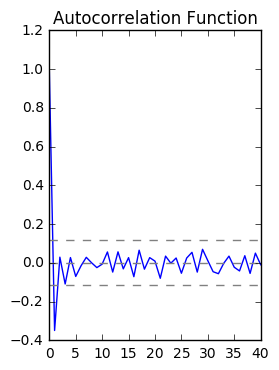

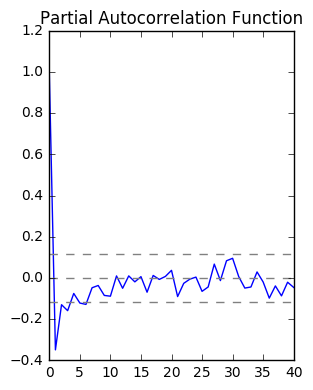

In [46]:
'''ACF is applied to compute MA value; '''
lag_acf = acf(ts_log_diff, nlags=40)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

lag_pacf = pacf(ts_log_diff, nlags=40, method='ols')
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

/Users/sujaya/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sujaya/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sujaya/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sujaya/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sujaya/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization f

Time
2013-02-12    14.540000
2013-02-27    14.546234
2013-03-01    13.562900
2013-07-31    12.521238
2013-08-06    12.878914
2013-08-09    13.169368
2013-08-12    13.408690
2013-08-16    13.607888
2013-08-26    13.774989
2013-09-01    13.916103
dtype: float64
1 1


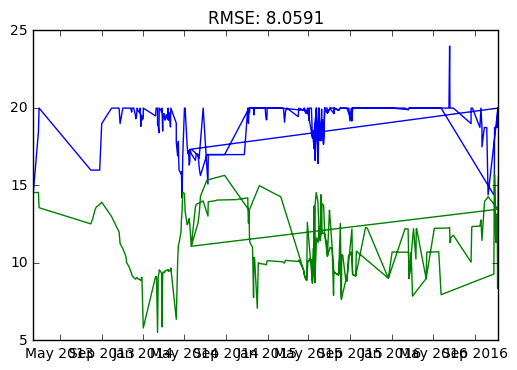

In [97]:

def predictPrice(p, q):
    mae, predictions_ARIMA = None, None
    try:
        model = ARIMA(ts_log, order=(p,1,q))  
        results_ARIMA = model.fit(disp=-1)
        predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
        predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
        predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
        for ind, val in predictions_ARIMA_diff_cumsum.iteritems():
            predictions_ARIMA_log[ind] =  predictions_ARIMA_log[ind] + val
        predictions_ARIMA = np.exp(predictions_ARIMA_log)

        #rmse = np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts))
        mae = mean_absolute_error(ts, predictions_ARIMA)

    except:
        pass
    return mae, predictions_ARIMA

minMae = 9999
for i in xrange(1,6):
    for j in xrange(1,5):
        mae, predictions_ARIMA = predictPrice(i,j)
        
        if mae and not predictions_ARIMA.empty and mae < minMae:
            minMae = mae
            p, q = i, j
            best_predictions_ARIMA = predictions_ARIMA

print best_predictions_ARIMA.head(10)
print p, q
plt.plot(ts, color='blue')
plt.plot(best_predictions_ARIMA, color='green')
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
plt.title('RMSE: %.4f'% mean_absolute_error(ts, best_predictions_ARIMA))#np.sqrt(sum((best_predictions_ARIMA-ts)**2)/len(ts)))
plt.show()

286
